In [1]:
!nvidia-smi

Sun Apr  9 09:52:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [78]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import normalize
from skimage import measure, color, io
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed = seed

In [4]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [6]:
!cp -r /content/drive/MyDrive/dent.zip -d /content
!unzip -q /content/dent.zip

In [7]:
SIZE = 256

image_path = '/content/dent/train/image'
mask_path = '/content/dent/train/label'

image_dataset = []
mask_dataset = []

In [8]:
images = os.listdir(image_path)
print('total images',len(images))

for i, image in enumerate(images):
  path = os.path.join(image_path,image)
  # img = cv2.imread(path,0)
  img = cv2.imread(path)
  img = cv2.resize(img,(SIZE,SIZE),interpolation = cv2.INTER_AREA)
  img = img/255.0
  image_dataset.append(img)

total images 41


In [9]:
masks = os.listdir(mask_path)
print('total masks',len(masks))

for i, mask in enumerate(masks):
  path = os.path.join(mask_path,mask)
  # img = cv2.imread(path,0)
  img = cv2.imread(path,0)
  img = cv2.resize(img,(SIZE,SIZE),interpolation = cv2.INTER_AREA)
  mask_dataset.append(img)

total masks 41


In [10]:
# image_dataset = np.expand_dims(normalize(np.array(image_dataset),axis=1),3)
image_dataset = np.array(image_dataset)
print(image_dataset.shape)

(41, 256, 256, 3)


In [11]:
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)/255.
print(mask_dataset.shape)

(41, 256, 256, 1)


In [12]:
X_train,X_test,y_train,y_test = train_test_split(image_dataset,mask_dataset,test_size = 0.2)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (32, 256, 256, 3)
X_test (9, 256, 256, 3)
y_train (32, 256, 256, 1)
y_test (9, 256, 256, 1)


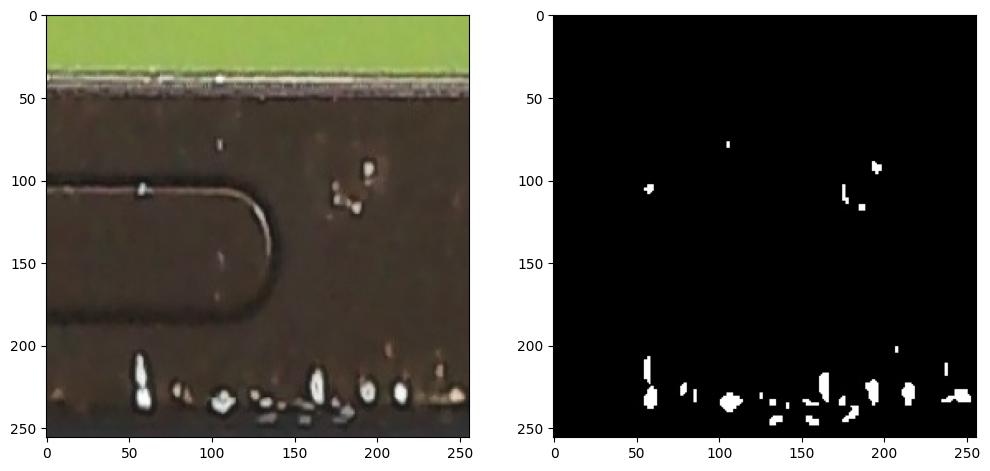

In [13]:
image_number = random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number],(256,256,3)),cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number],(256,256)),cmap='gray')

In [14]:
IMG_HEIGHT = SIZE
IMG_WIDTH = SIZE
IMG_CHANNELS = 3

In [15]:
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [16]:
history = model.fit(X_train,y_train,
                    batch_size= 12,
                    verbose=2, # 0,1,2
                    epochs=300,
                    validation_data = (X_test,y_test),
                    shuffle=False
                    )

Epoch 1/300
3/3 - 26s - loss: 0.6903 - accuracy: 0.8651 - val_loss: 0.6822 - val_accuracy: 0.9094 - 26s/epoch - 9s/step
Epoch 2/300
3/3 - 0s - loss: 0.6627 - accuracy: 0.8753 - val_loss: 0.5088 - val_accuracy: 0.8557 - 400ms/epoch - 133ms/step
Epoch 3/300
3/3 - 0s - loss: 0.4576 - accuracy: 0.8590 - val_loss: 0.4420 - val_accuracy: 0.9078 - 402ms/epoch - 134ms/step
Epoch 4/300
3/3 - 0s - loss: 0.3635 - accuracy: 0.8989 - val_loss: 0.3557 - val_accuracy: 0.9082 - 398ms/epoch - 133ms/step
Epoch 5/300
3/3 - 0s - loss: 0.2966 - accuracy: 0.9007 - val_loss: 0.2322 - val_accuracy: 0.9089 - 402ms/epoch - 134ms/step
Epoch 6/300
3/3 - 0s - loss: 0.2880 - accuracy: 0.9018 - val_loss: 0.3680 - val_accuracy: 0.9093 - 399ms/epoch - 133ms/step
Epoch 7/300
3/3 - 0s - loss: 0.2863 - accuracy: 0.9024 - val_loss: 0.2496 - val_accuracy: 0.9093 - 443ms/epoch - 148ms/step
Epoch 8/300
3/3 - 0s - loss: 0.2628 - accuracy: 0.9025 - val_loss: 0.2295 - val_accuracy: 0.9093 - 439ms/epoch - 146ms/step
Epoch 9/300


In [ ]:
# evaluate the model
_,acc = model.evaluate(X_test,y_test)
print('Accuracy=',(acc*100.0),'%')

1/1 [==============================] - 0s 56ms/step - loss: 0.1100 - accuracy: 0.9348
Accuracy= 93.47703456878662 %


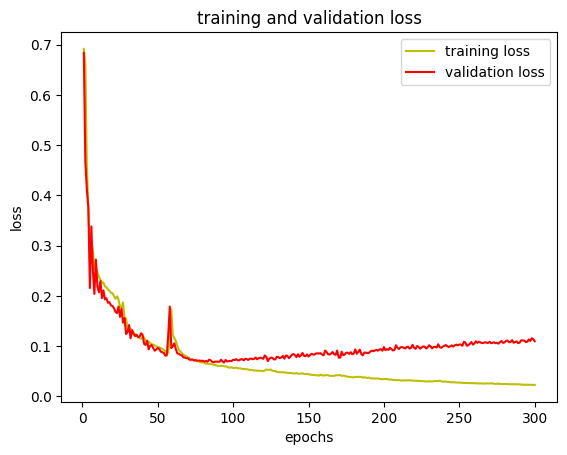

In [ ]:
# plot the training and validation accuracy an loss each epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

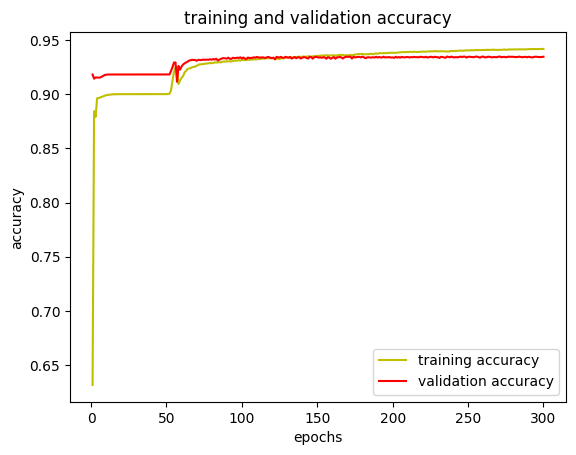

In [ ]:
# plot the training and validation accuracy an loss each epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs =range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label='training accuracy')
plt.plot(epochs,val_acc,'r',label='validation accuracy')
plt.title('training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.3

intersection = np.logical_and(y_test,y_pred_thresholded)
union = np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print('IoU score is',iou_score)

1/1 [==============================] - 0s 232ms/step
IoU score is 0.44044158233670655


(256, 256, 3)
(256, 256, 1)
(1, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
(256, 256, 1)


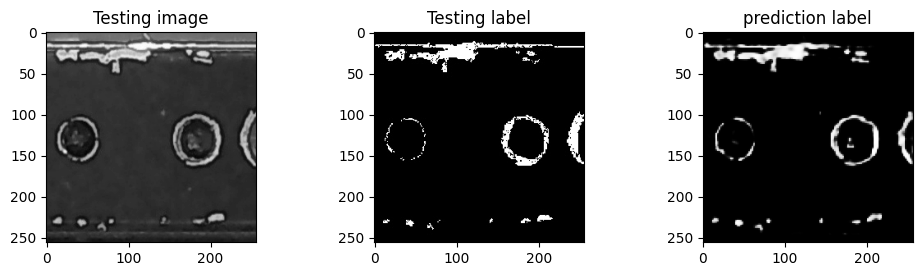

In [86]:
test_img_number = random.randint(0,len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
ground_truth = y_test[test_img_number]
print(ground_truth.shape)
test_img_input = np.expand_dims(test_img,0)
print(test_img_input.shape)
prediction = model.predict(test_img_input)[0]
print(prediction.shape)

plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0],cmap='gray')
plt.subplot(232)
plt.title('Testing label')
plt.imshow(ground_truth[:,:,0],cmap='gray')
plt.subplot(233)
plt.title('prediction label')
plt.imshow(prediction,cmap='gray')

# Watershed 

instance segmentation

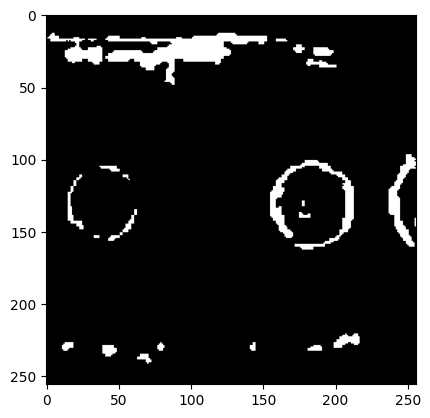

In [88]:
images = os.listdir('/content/dent/test')
image = random.choice(images)
image_path = os.path.join('/content/dent/test',image)

# img = cv2.imread(image_path)
# print(img.shape)
# gray = img[:,:,0]
# print(gray.shape)

prediction  = prediction * 255
prediction = prediction.astype('uint8')

ret,thresh = cv2.threshold(prediction,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh,cmap='gray')

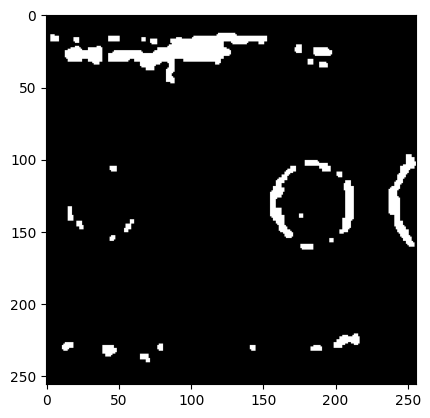

In [89]:
# Morphological operations to remove small noise - opening
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations = 1)
plt.imshow(opening,cmap='gray')

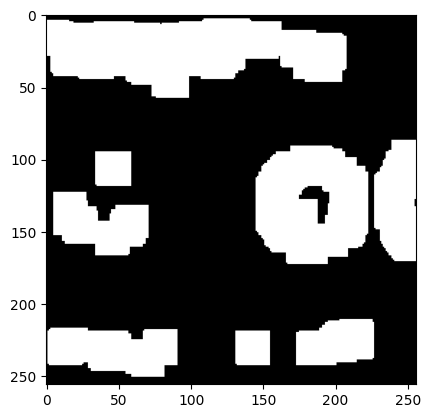

In [90]:
sure_bg = cv2.dilate(opening,kernel,iterations=10)
sure_bg = sure_bg.astype(np.uint8)
plt.imshow(sure_bg,cmap='gray')

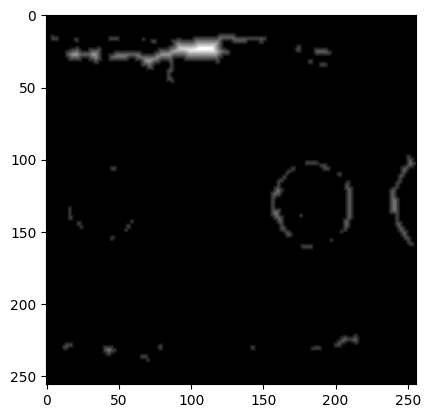

In [91]:
# find the foreground area using distance transform and thresholding
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.imshow(dist_transform,cmap='gray')

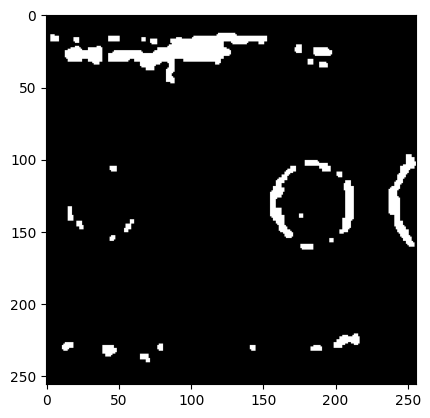

In [98]:
# let threshold the dist tranform by starting at 1/2 its max value
ret2,sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
sure_fg = sure_fg.astype(np.uint8)
plt.imshow(sure_fg,cmap='gray')

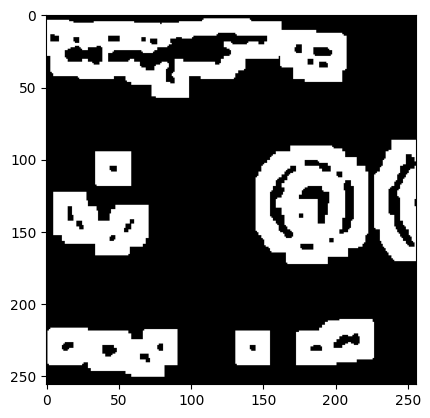

In [99]:
# unknown ambigous region is background - foreground
unknown = cv2.subtract(sure_bg,sure_fg) # sure_bg - sure_fg
plt.imshow(unknown,cmap='gray')

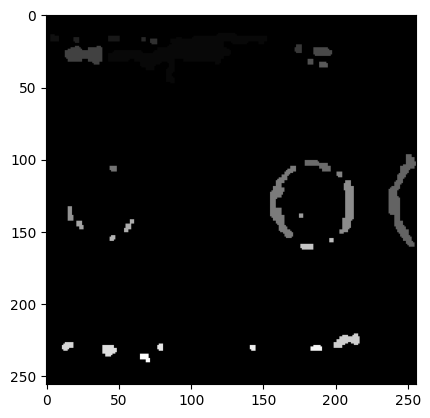

In [100]:
# for markers let us use connectedComponents
ret,markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers,cmap='gray')

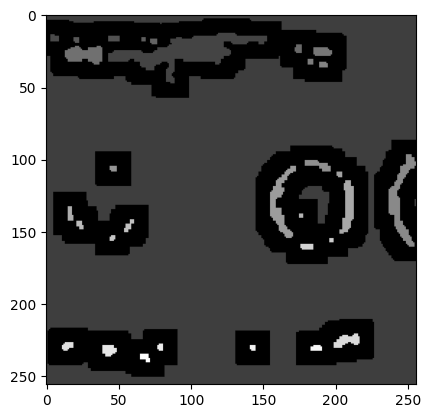

In [101]:
markers = markers + 10
# mark the region of unknown with zero
markers[unknown==255] =0

plt.imshow(markers,cmap='gray')

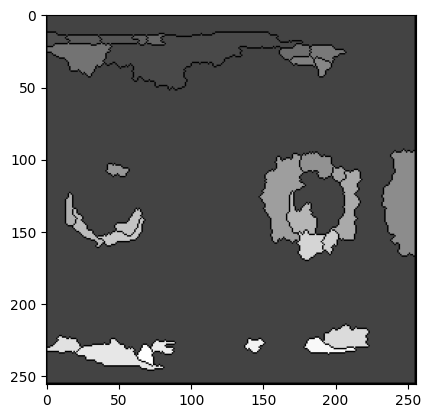

In [102]:
# now we are ready for watershed filling
markers = cv2.watershed(img,markers)
plt.imshow(markers,cmap='gray')

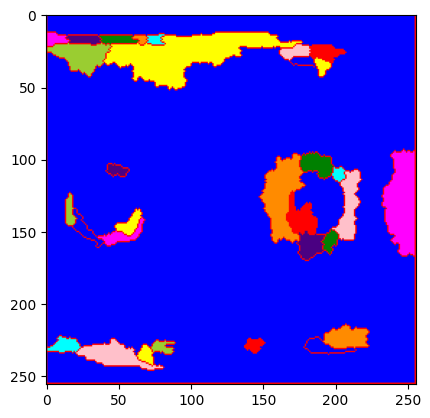

In [103]:
# boundary with zero
img[markers==-1] = [0,255,255]
img2 = color.label2rgb(markers,bg_label=0)
plt.imshow(img2)